## In this notebook I will augment data using CTGAN and check ML model performance (baseline) 

#### Dataset: "iris.csv"

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import scipy.linalg
import io
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder

In [37]:
def load_and_analyze_csv(file_path):
    """
    Load a CSV file and provide basic analysis
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        DataFrame with the loaded data
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Basic information
    print(f"Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
    print(f"Missing values: {df.isna().sum().sum()}")
    
    # Data types information
    dtypes_df = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes.values,
        'Non-Null Count': df.count().values,
        'Missing Values': df.isna().sum().values,
        'Missing Percentage': (df.isna().sum().values / len(df) * 100).round(2)
    })
    
    print("\nData Types:")
    display(dtypes_df)
    
    # Preview the data
    print("\nData Preview:")
    display(df.head())
    
    return df



In [38]:
def exploratory_analysis(df):
    """
    Perform exploratory data analysis on a DataFrame
    
    Args:
        df: Pandas DataFrame to analyze
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset.")
        return
    
    print(f"Found {len(numeric_cols)} numeric columns that will be analyzed")
    
    # Basic statistics
    print("\nBasic Statistics:")
    display(df[numeric_cols].describe())
    
    # Correlation matrix
    print("\nCorrelation Matrix:")
    plt.figure(figsize=(12, 10))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Distribution plots
    print("\nDistribution of Numerical Features:")
    for i, col in enumerate(numeric_cols):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        
        plt.tight_layout()
        plt.show()
    
    # PCA visualization if we have more than 2 numeric columns
    if len(numeric_cols) > 2:
        print("\nPCA Visualization:")
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(df[numeric_cols])
        
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA: First Two Principal Components')
        plt.tight_layout()
        plt.show()
        
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")



In [54]:
class CTGAN(nn.Module):
    """Conditional Tabular GAN - better for tabular data than vanilla GAN"""
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Generator with residual connections
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        
        # Discriminator with spectral normalization for stability
        self.discriminator = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, 1)),
            nn.Sigmoid()
        )
    
    def generate(self, batch_size):
        device = next(self.generator.parameters()).device
        z = torch.randn(batch_size, self.latent_dim).to(device)
        return self.generator(z)

def train_gan_and_generate(df, numeric_cols, num_epochs=50, num_samples=100, batch_size=64, latent_dim=64):
    """
    Train a GAN model on numerical data and generate synthetic samples
    
    Args:
        df: Pandas DataFrame with the data
        numeric_cols: List of numerical column names
        num_epochs: Number of training epochs
        num_samples: Number of synthetic samples to generate
        batch_size: Batch size for training
        latent_dim: Latent dimension for the generator
        
    Returns:
        DataFrame with synthetic data
    """
    # Extract numerical data
    original_data = df[numeric_cols].values
    
    # Normalize data for better GAN training
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(original_data)
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model
    input_dim = original_data.shape[1]
    model = CTGAN(input_dim=input_dim, latent_dim=latent_dim).to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Training data
    X = torch.tensor(scaled_data, dtype=torch.float32).to(device)
    train_dataloader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)
    
    # Training history
    history = {'G_loss': [], 'D_loss': []}
    
    # Training loop
    for epoch in range(num_epochs):
        g_losses, d_losses = [], []
        
        for real_data in train_dataloader:
            current_batch = real_data.size(0)
            valid = torch.ones(current_batch, 1).to(device)
            fake = torch.zeros(current_batch, 1).to(device)
            
            # Label smoothing for stability
            valid = valid - 0.1 * torch.rand_like(valid)
            fake = fake + 0.1 * torch.rand_like(fake)

            # Train Discriminator
            optimizer_D.zero_grad()
            pred_real = model.discriminator(real_data)
            loss_real = criterion(pred_real, valid)
            
            # Generate fake data
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_data = model.generator(z)
            pred_fake = model.discriminator(fake_data.detach())
            loss_fake = criterion(pred_fake, fake)
            
            # Total discriminator loss
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(current_batch, latent_dim).to(device)
            fake_data = model.generator(z)
            pred_fake = model.discriminator(fake_data)
            loss_G = criterion(pred_fake, valid)
            loss_G.backward()
            optimizer_G.step()
            
            g_losses.append(loss_G.item())
            d_losses.append(loss_D.item())
        
        # Update progress
        avg_g_loss = sum(g_losses) / len(g_losses)
        avg_d_loss = sum(d_losses) / len(d_losses)
        history['G_loss'].append(avg_g_loss)
        history['D_loss'].append(avg_d_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {avg_d_loss:.4f}, Loss G: {avg_g_loss:.4f}")
    
    print("GAN training complete!")
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history['G_loss'], label='Generator Loss')
    plt.plot(history['D_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()
    
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        synthetic_tensor = model.generator(z)
        synthetic = synthetic_tensor.cpu().numpy()
        
    # Inverse transform to original scale
    synthetic = scaler.inverse_transform(synthetic)
    
    # Create DataFrame with synthetic data
    synthetic_df = pd.DataFrame(synthetic, columns=numeric_cols)
    
    # Truncate all values to 2 decimal places
    for col in synthetic_df.columns:
        # Check if the column is 'species_numeric' which should remain as integers
        if col == 'species_numeric':
            synthetic_df[col] = synthetic_df[col].round().astype(int)
        else:
            # Truncate to 2 decimal places
            synthetic_df[col] = (synthetic_df[col] * 100).astype(int) / 100
            
    return synthetic_df

def compare_distributions(original_df, synthetic_df, numeric_cols):
    """
    Compare distributions between original and synthetic data
    
    Args:
        original_df: DataFrame with original data
        synthetic_df: DataFrame with synthetic data
        numeric_cols: List of numerical column names to compare
    """
    # PCA visualization
    print("PCA Visualization: Original vs Synthetic Data")
    original_data = original_df[numeric_cols].values
    synthetic_data = synthetic_df[numeric_cols].values
    
    # Combine data for PCA
    combined_data = np.vstack([original_data, synthetic_data])
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data)
    
    # Split results back
    n_original = original_data.shape[0]
    original_pca = pca_result[:n_original]
    synthetic_pca = pca_result[n_original:]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(original_pca[:, 0], original_pca[:, 1], color='blue', label="Original Data", s=20, alpha=0.7)
    plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], color='red', label="Synthetic Data", s=20, alpha=0.7)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA: Original vs Synthetic Data")
    plt.legend()
    plt.show()
    
    # t-SNE visualization
    print("\nt-SNE Visualization: Original vs Synthetic Data")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(combined_data)
    
    # Split results back
    original_tsne = tsne_result[:n_original]
    synthetic_tsne = tsne_result[n_original:]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(original_tsne[:, 0], original_tsne[:, 1], color='blue', label="Original Data", s=20, alpha=0.7)
    plt.scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], color='red', label="Synthetic Data", s=20, alpha=0.7)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE: Original vs Synthetic Data")
    plt.legend()
    plt.show()
    
    # Statistical comparison
    print("\nStatistical Comparison:")
    print("\nOriginal Data Statistics:")
    display(original_df[numeric_cols].describe())
    print("\nSynthetic Data Statistics:")
    display(synthetic_df[numeric_cols].describe())
    
    # Feature distribution comparison
    print("\nFeature Distribution Comparison:")
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(original_df[col], label='Original')
        sns.kdeplot(synthetic_df[col], label='Synthetic')
        plt.title(f'Distribution Comparison: {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Calculate Jensen-Shannon Divergence for each feature
    print("\nDistribution Similarity (Jensen-Shannon Divergence):")
    js_divergences = []
    
    for col in numeric_cols:
        # Get probability distributions using KDE
        kde_orig = stats.gaussian_kde(original_df[col].dropna())
        kde_syn = stats.gaussian_kde(synthetic_df[col].dropna())
        
        # Evaluate both distributions on a common support
        x_range = np.linspace(min(original_df[col].min(), synthetic_df[col].min()),
                             max(original_df[col].max(), synthetic_df[col].max()), 100)
        p = kde_orig(x_range)
        q = kde_syn(x_range)
        
        # Normalize to ensure they sum to 1
        p = p / p.sum()
        q = q / q.sum()
        
        # Calculate JS divergence
        m = 0.5 * (p + q)
        js_div = 0.5 * (stats.entropy(p, m) + stats.entropy(q, m))
        js_divergences.append((col, js_div))
    
    # Display JS divergences
    js_df = pd.DataFrame(js_divergences, columns=['Feature', 'JS Divergence'])
    js_df = js_df.sort_values('JS Divergence')
    
    # Plot JS divergences
    plt.figure(figsize=(10, 6))
    sns.barplot(data=js_df, x='Feature', y='JS Divergence')
    plt.xticks(rotation=45)
    plt.title('Jensen-Shannon Divergence (lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show numeric values
    print("Jensen-Shannon Divergence for each feature (lower is better):")
    display(js_df)
    
    # Correlation matrix comparison
    print("\nCorrelation Matrix Comparison:")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original correlation matrix
    corr_orig = original_df[numeric_cols].corr()
    sns.heatmap(corr_orig, ax=ax1, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", cbar=False)
    ax1.set_title('Original Data Correlations')
    
    # Synthetic correlation matrix
    corr_syn = synthetic_df[numeric_cols].corr()
    sns.heatmap(corr_syn, ax=ax2, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", cbar=True)
    ax2.set_title('Synthetic Data Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate FID score
    print("\nFréchet Inception Distance (FID):")
    
    def calculate_fid(real_data, synthetic_data):
        # Calculate statistics for real and synthetic data
        mu1, sigma1 = real_data.mean(axis=0), np.cov(real_data, rowvar=False)
        mu2, sigma2 = synthetic_data.mean(axis=0), np.cov(synthetic_data, rowvar=False)
        
        # Calculate squared difference between means
        diff = mu1 - mu2
        
        # Calculate matrix sqrt
        covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
        
        # Check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        # Calculate FID
        fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
        return fid
    
    try:
        fid_score = calculate_fid(original_data, synthetic_data)
        print(f"Fréchet Inception Distance (lower is better): {fid_score:.2f}")
    except Exception as e:
        print(f"Could not calculate FID score: {e}")




In [56]:
def analyze_and_generate(file_path, num_epochs=50, num_samples=100):
    """
    Complete analysis pipeline: load data, perform EDA, generate synthetic data, and compare
    
    Args:
        file_path: Path to the CSV file
        num_epochs: Number of training epochs for GAN
        num_samples: Number of synthetic samples to generate
    """
    print("=" * 80)
    print(f"Analyzing CSV file: {file_path}")
    print("=" * 80)
    
    # Load and analyze the data
    df = load_and_analyze_csv(file_path)
    
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    if len(numeric_cols) == 0:
        print("No numerical columns found in the dataset. Cannot proceed with analysis.")
        return
    
    print("\n" + "=" * 80)
    print("Exploratory Data Analysis")
    print("=" * 80)
    exploratory_analysis(df)
    
    print("\n" + "=" * 80)
    print("Generating Synthetic Data")
    print("=" * 80)
    synthetic_df = train_gan_and_generate(df, numeric_cols, num_epochs=num_epochs, num_samples=num_samples)
    
    print("\n" + "=" * 80)
    print("Comparing Original and Synthetic Data")
    print("=" * 80)
    compare_distributions(df, synthetic_df, numeric_cols)
    
    print("\nAnalysis complete!")
    
    return df, synthetic_df



Original Iris Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Iris Dataset with Numerical Species:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2 

,Column,Data Type,Non-Null Count,Missing Values,Missing Percentage
0,sepal length (cm),float64,150,0,0.0
1,sepal width (cm),float64,150,0,0.0
2,petal length (cm),float64,150,0,0.0
3,petal width (cm),float64,150,0,0.0
4,species,object,150,0,0.0
5,species_numeric,int64,150,0,0.0



Data Preview:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_numeric
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0



Exploratory Data Analysis
Found 5 numeric columns that will be analyzed

Basic Statistics:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_numeric
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



Correlation Matrix:


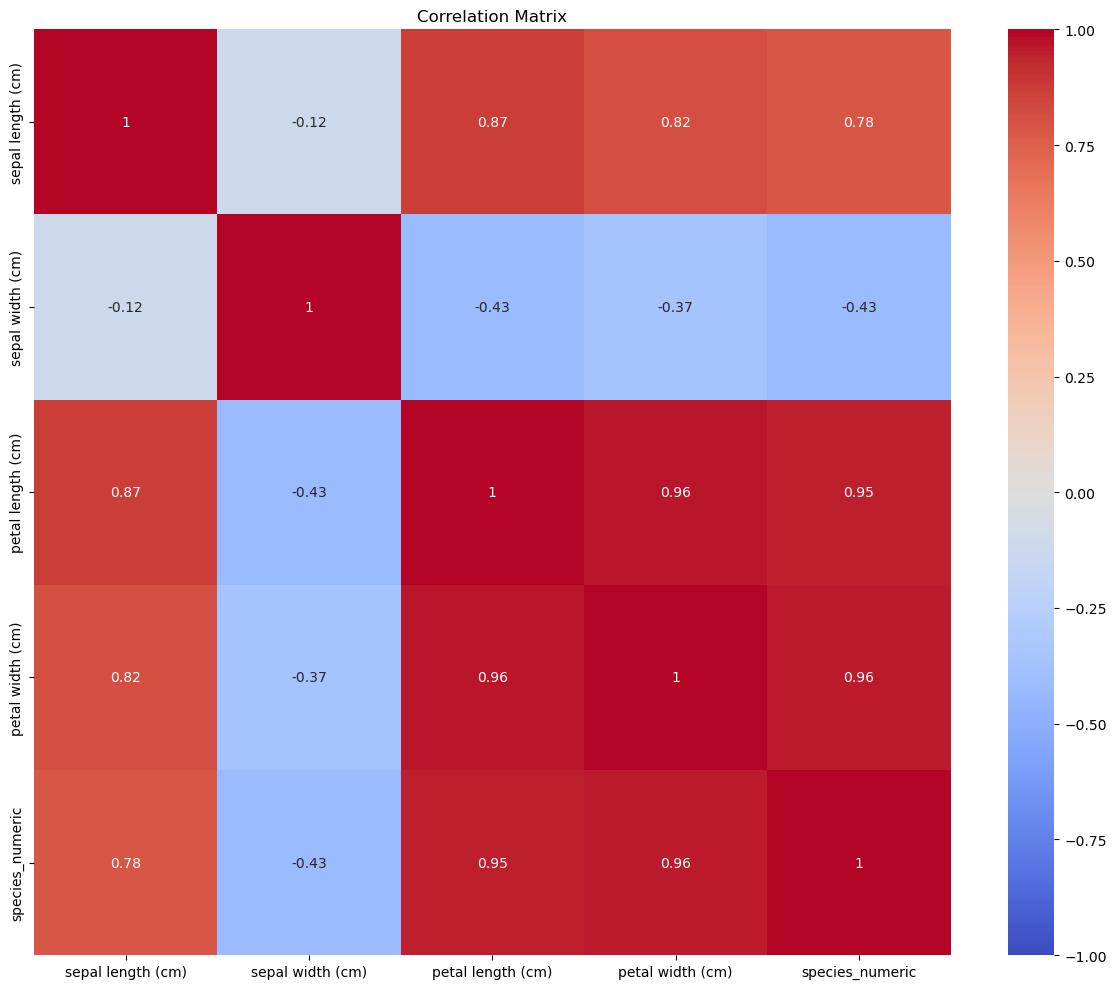


Distribution of Numerical Features:


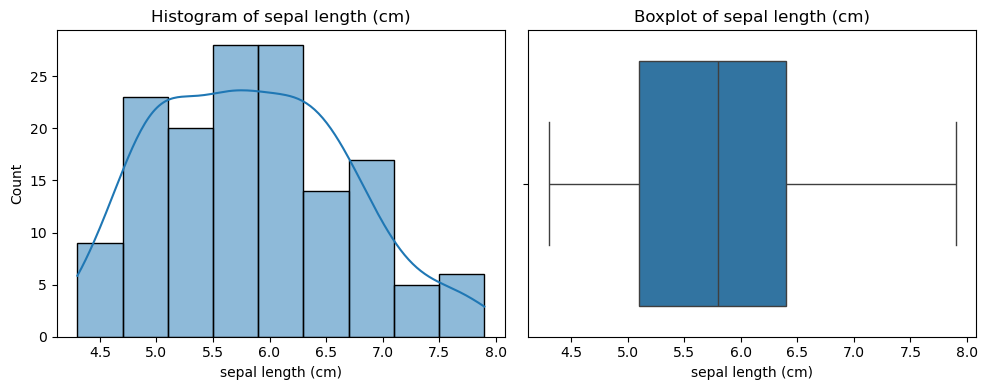

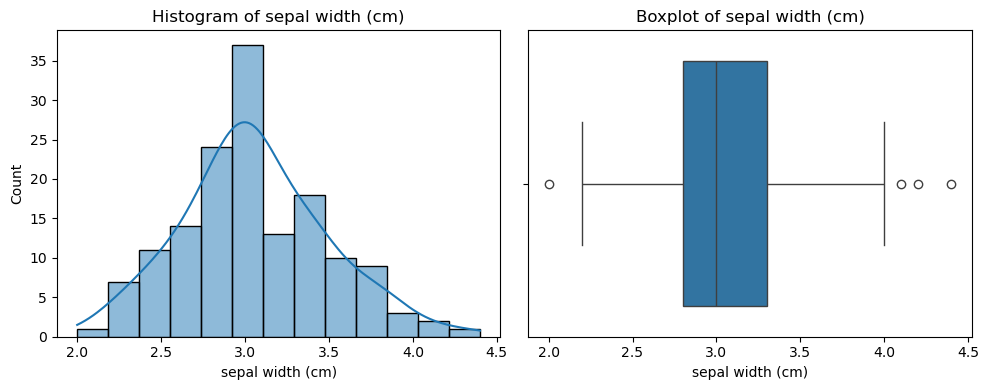

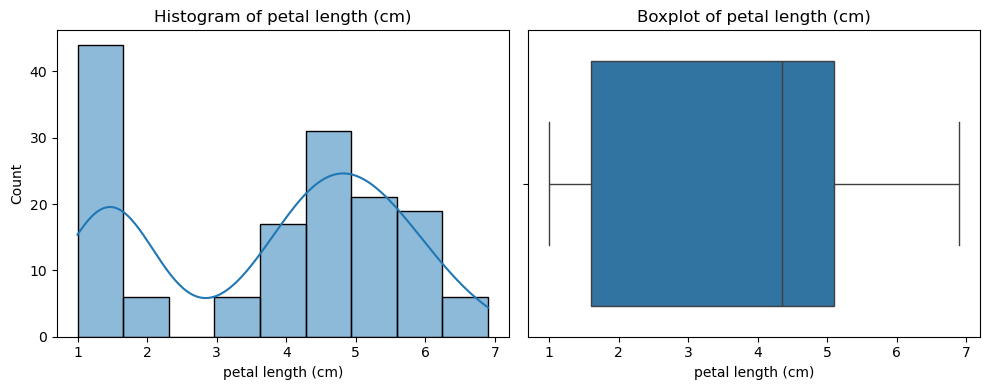

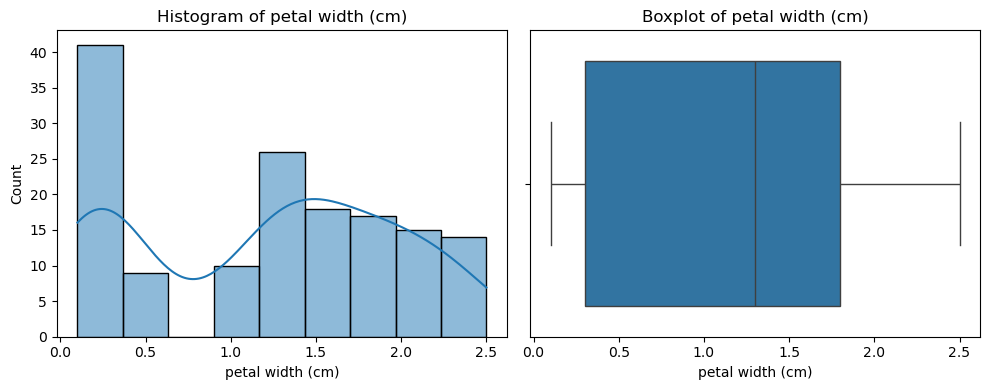

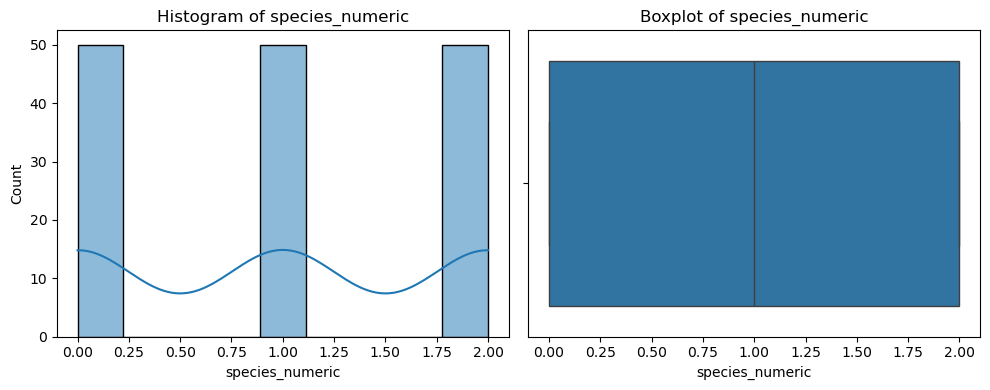


PCA Visualization:


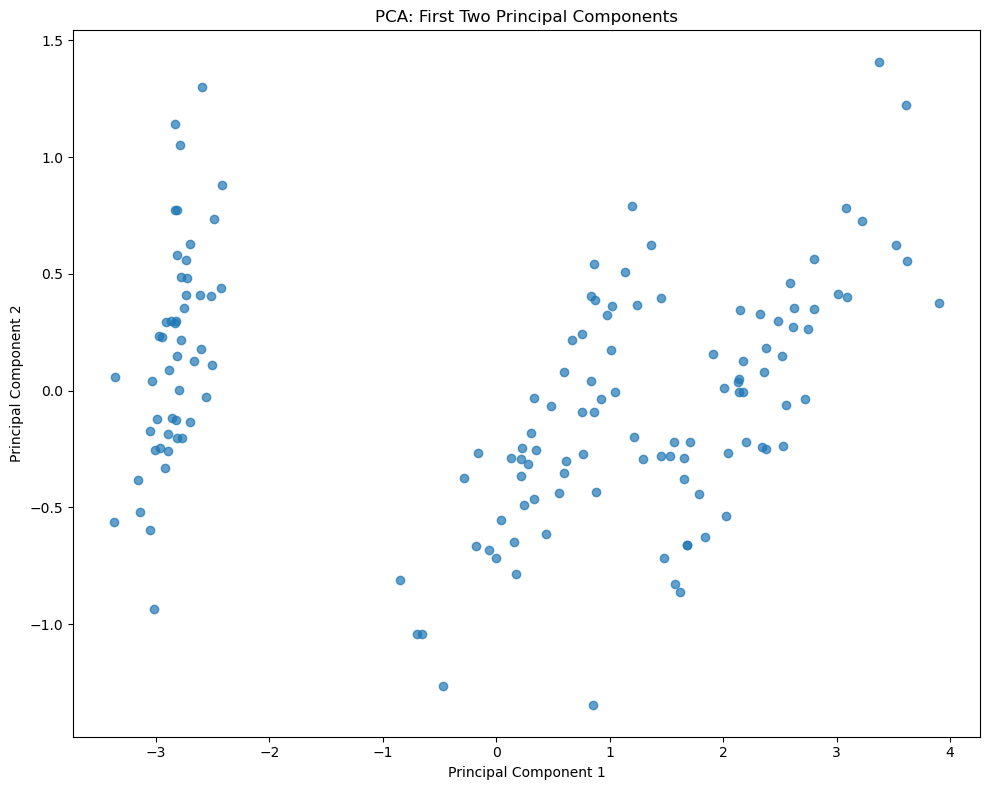

Explained variance ratio: [0.92264373 0.04812763]

Generating Synthetic Data
Using device: cuda
Epoch [1/50], Loss D: 0.6938, Loss G: 0.6820
Epoch [5/50], Loss D: 0.6897, Loss G: 0.6995
Epoch [10/50], Loss D: 0.6933, Loss G: 0.6886
Epoch [15/50], Loss D: 0.6915, Loss G: 0.6968
Epoch [20/50], Loss D: 0.6925, Loss G: 0.6951
Epoch [25/50], Loss D: 0.6917, Loss G: 0.6954
Epoch [30/50], Loss D: 0.6926, Loss G: 0.6921
Epoch [35/50], Loss D: 0.6934, Loss G: 0.6965
Epoch [40/50], Loss D: 0.6923, Loss G: 0.6911
Epoch [45/50], Loss D: 0.6920, Loss G: 0.7006
Epoch [50/50], Loss D: 0.6928, Loss G: 0.6940
GAN training complete!


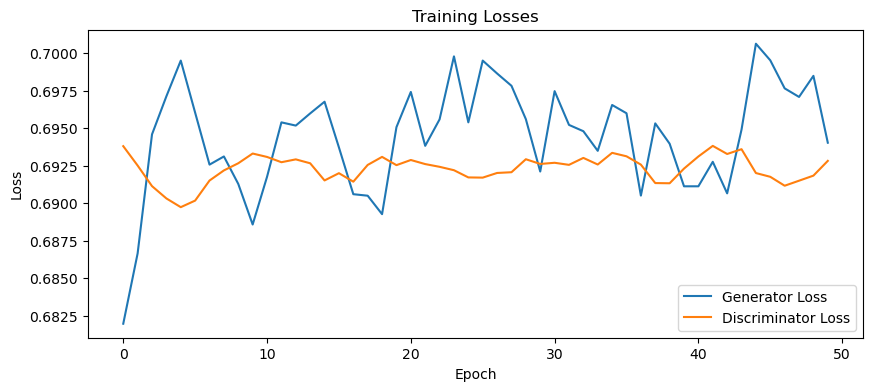


Comparing Original and Synthetic Data
PCA Visualization: Original vs Synthetic Data


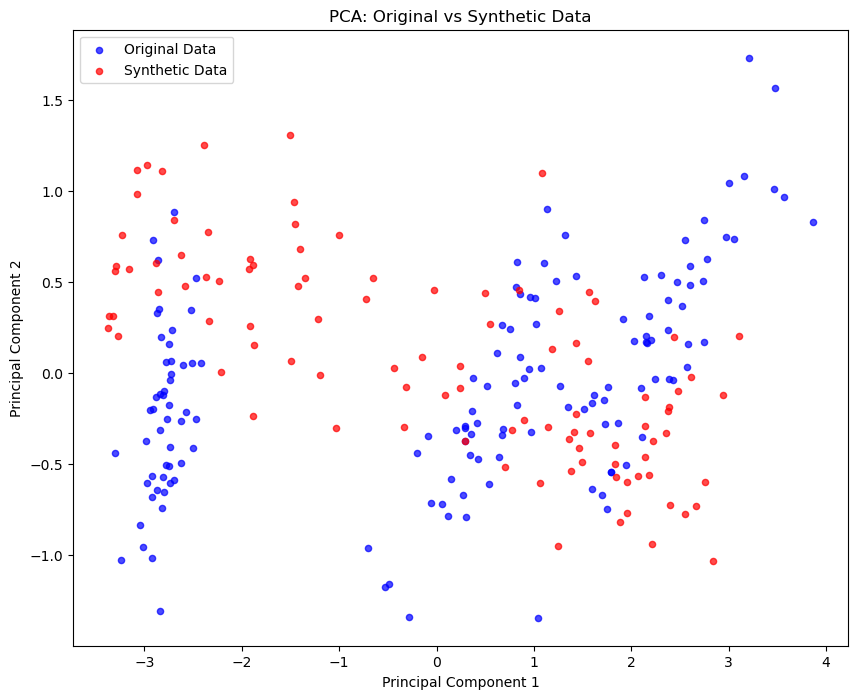


t-SNE Visualization: Original vs Synthetic Data


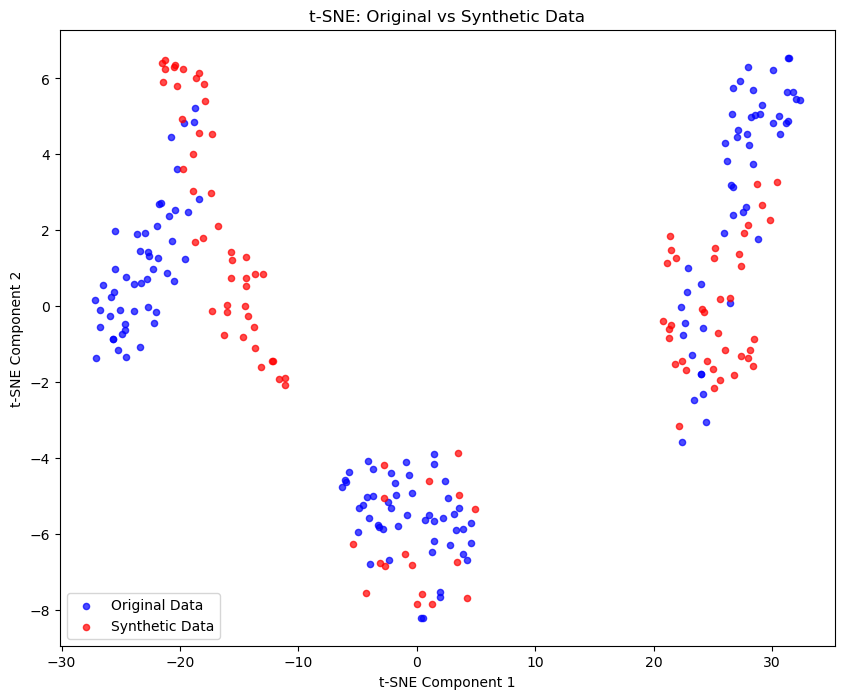


Statistical Comparison:

Original Data Statistics:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_numeric
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



Synthetic Data Statistics:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_numeric
count,100.000000,100.000000,100.000000,100.00000,100.000000
mean,5.979700,3.105600,3.684200,1.10240,0.930000
std,0.451385,0.670068,1.646562,0.75629,0.912926
min,4.880000,2.210000,1.000000,0.10000,0.000000
25%,5.667500,2.575000,2.225000,0.36000,0.000000
50%,5.995000,2.935000,4.100000,1.09000,1.000000
75%,6.250000,3.587500,5.107500,1.81000,2.000000
max,6.970000,4.390000,6.260000,2.38000,2.000000



Feature Distribution Comparison:


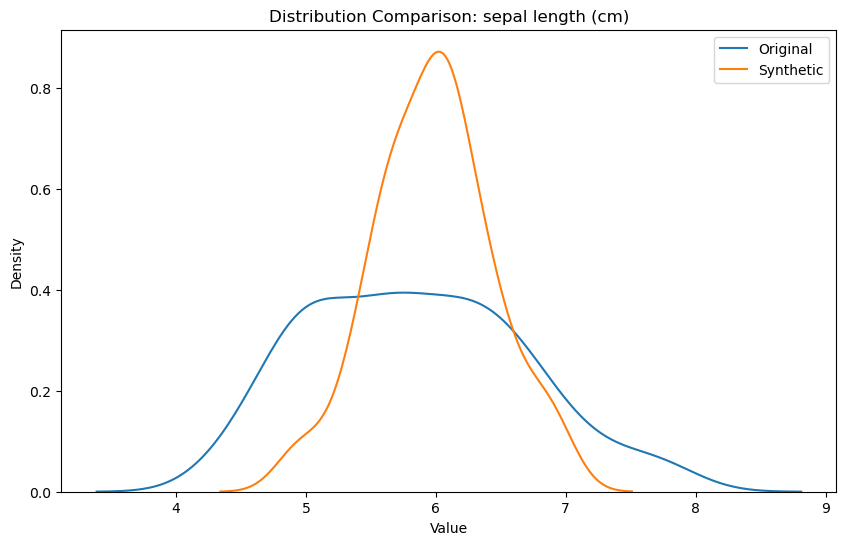

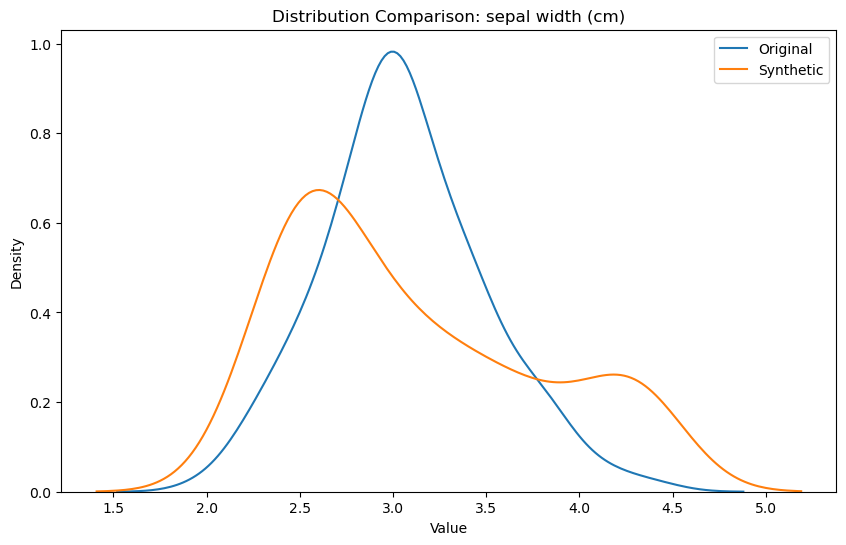

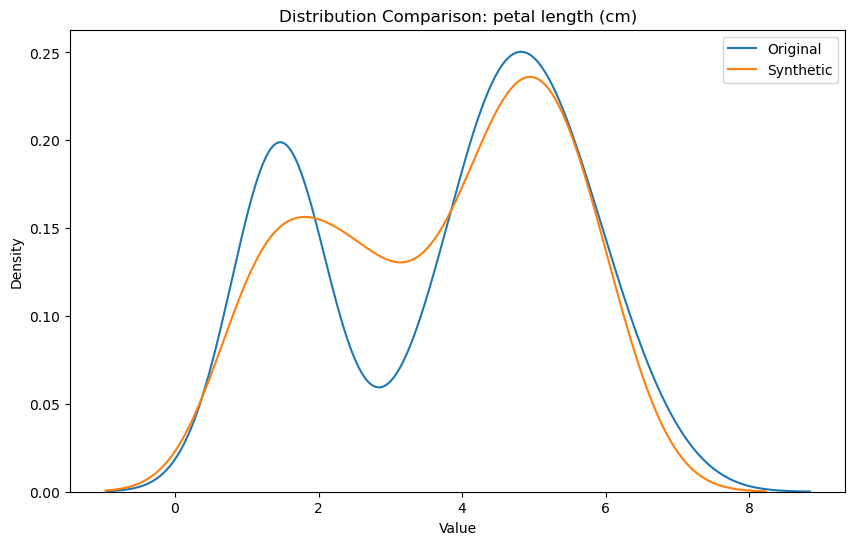

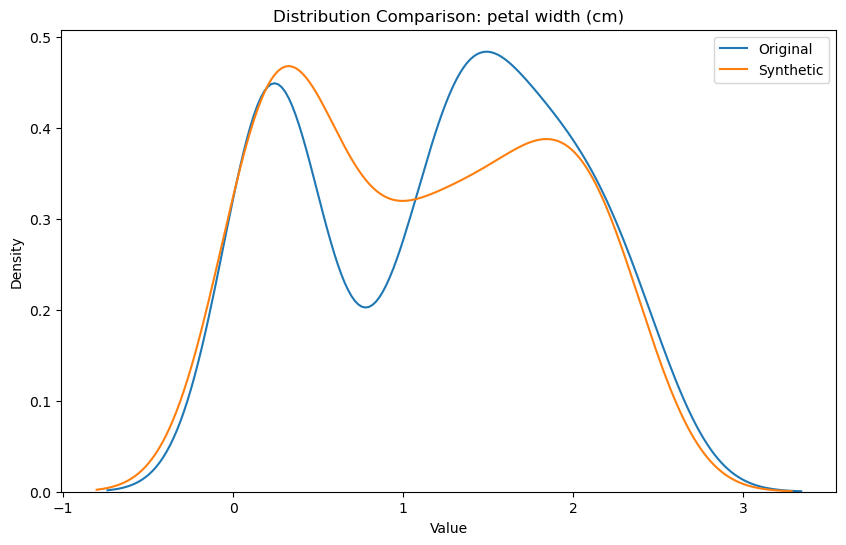

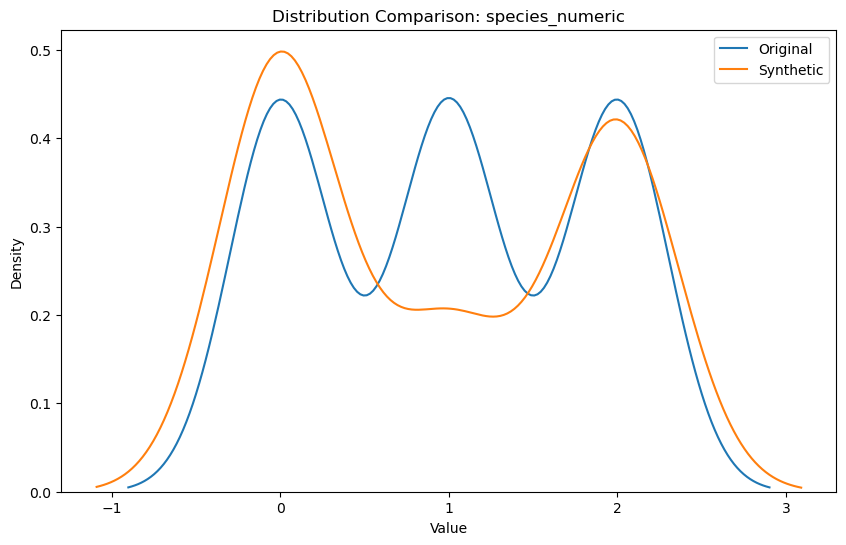


Distribution Similarity (Jensen-Shannon Divergence):


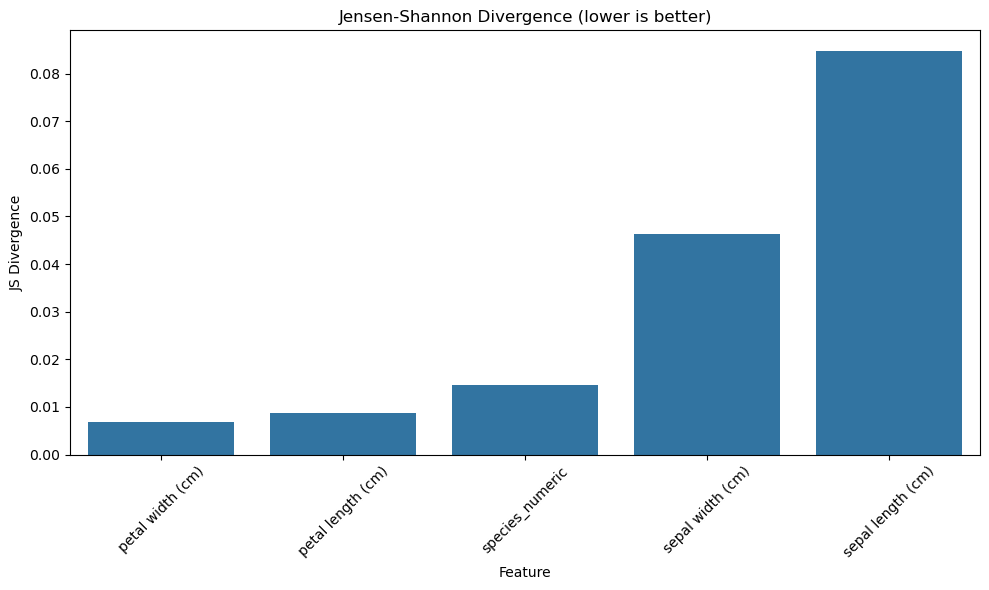

Jensen-Shannon Divergence for each feature (lower is better):


,Feature,JS Divergence
3,petal width (cm),0.006764
2,petal length (cm),0.008662
4,species_numeric,0.014526
1,sepal width (cm),0.046288
0,sepal length (cm),0.084847



Correlation Matrix Comparison:


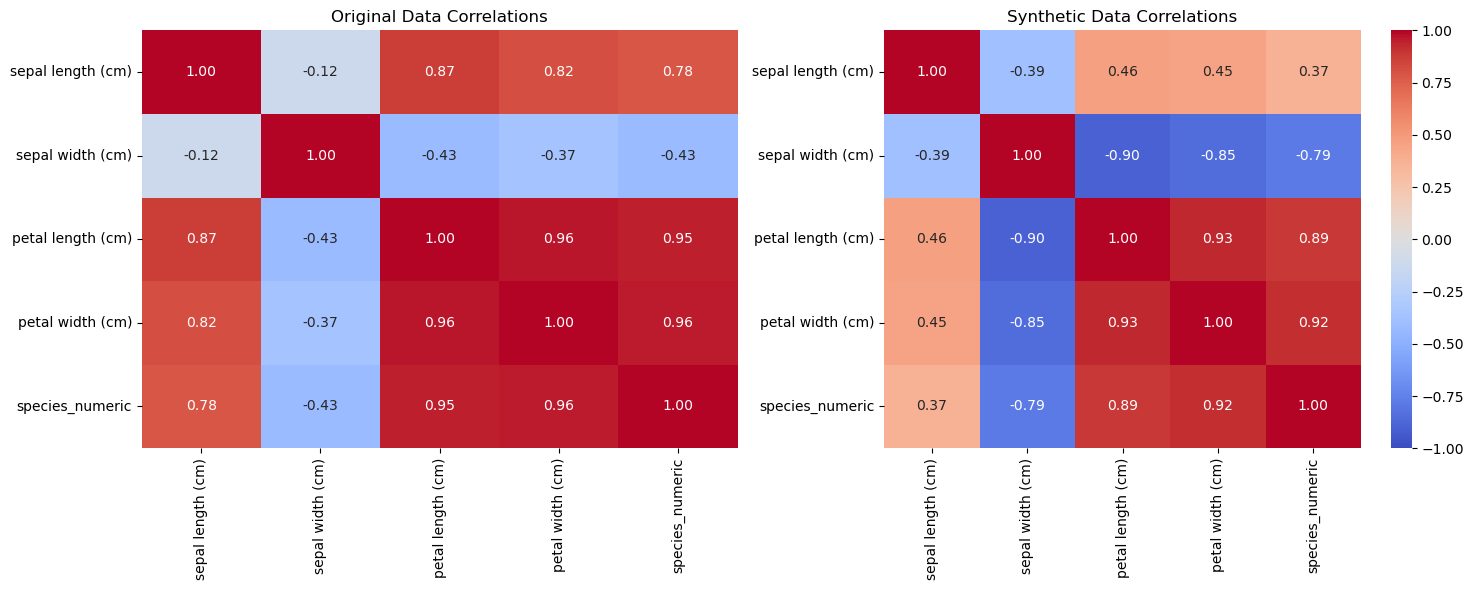


Fréchet Inception Distance (FID):
Fréchet Inception Distance (lower is better): 0.53

Analysis complete!


In [58]:
# Replace with your CSV file path
file_path = "iris_data_numerical.csv"

# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target_names[iris.target]

# Display the original dataset
print("Original Iris Dataset:")
print(df.head())

# Convert species to numerical values using LabelEncoder
label_encoder = LabelEncoder()
df['species_numeric'] = label_encoder.fit_transform(df['species'])

# Display the dataset with numerical species
print("\nIris Dataset with Numerical Species:")
print(df.head())

# Keep only numerical columns for GAN training
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"\nNumerical columns for GAN training: {numeric_cols}")

df.to_csv("iris_data_numerical.csv", index=False)

# Run the complete analysis
original_df, synthetic_df = analyze_and_generate(file_path, num_epochs=50, num_samples=100)

# Save the synthetic data to a new CSV file if needed
synthetic_df.to_csv("synthetic_iris_data.csv", index=False)


Original Iris Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
 5   species_numeric    150 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Original Iris Data Sample:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2 

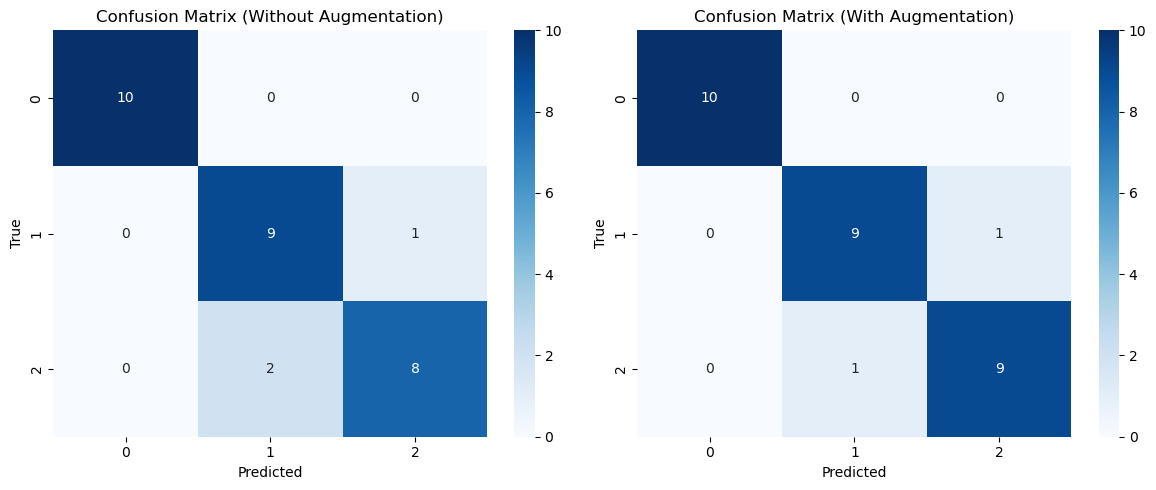

<Figure size 1000x600 with 0 Axes>

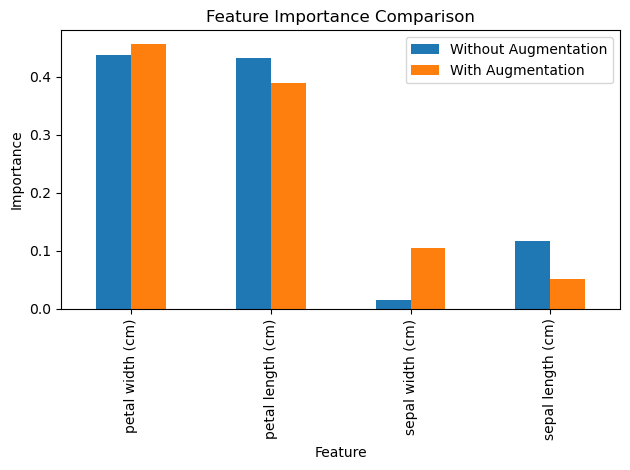

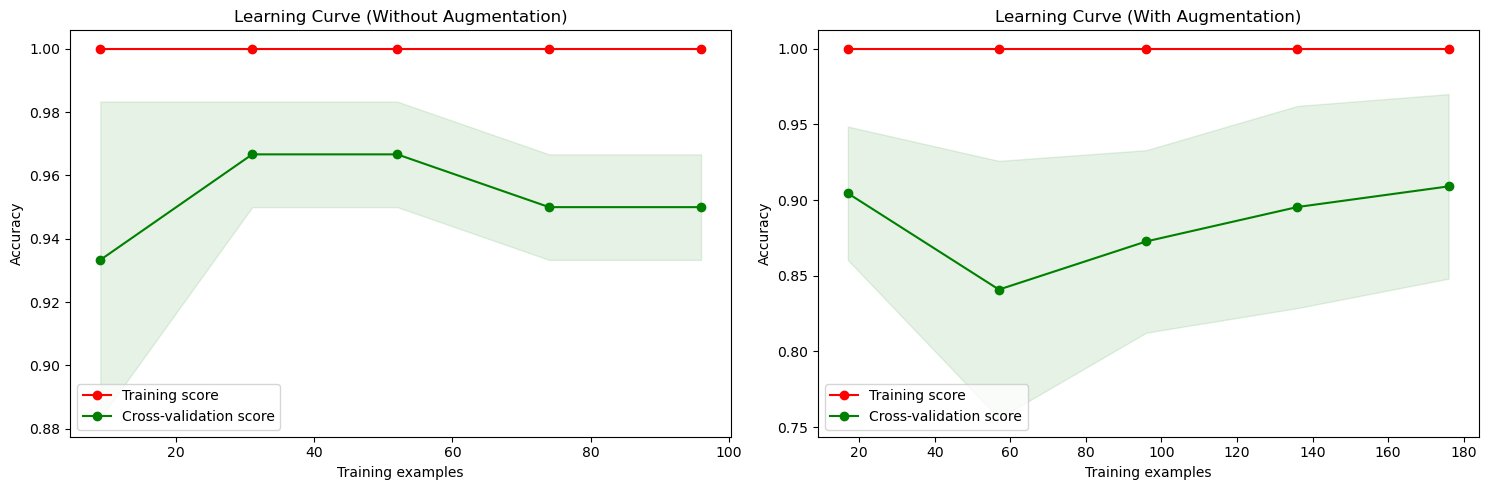

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the original iris data
original_df = pd.read_csv('iris_data_numerical.csv')

# Display detailed information about the dataframe
print("Original Iris Data Info:")
print(original_df.info())
print("\nOriginal Iris Data Sample:")
print(original_df.head())

# Load the synthetic iris data
synthetic_df = pd.read_csv('synthetic_iris_data.csv')
print("\nSynthetic Iris Data Info:")
print(synthetic_df.info())
print("\nSynthetic Iris Data Sample:")
print(synthetic_df.head())

# Explicitly identify and handle the species column
# First, check all columns that might contain categorical data
for col in original_df.columns:
    if original_df[col].dtype == 'object':
        print(f"\nColumn '{col}' contains string values: {original_df[col].unique()}")

# Create clean copies of the dataframes for processing
original_df_clean = original_df.copy()
synthetic_df_clean = synthetic_df.copy()

# Explicitly handle all object columns
for col in original_df.columns:
    if original_df[col].dtype == 'object':
        print(f"Converting column '{col}' to numeric...")
        
        # Create a label encoder for this column
        le = LabelEncoder()
        
        # Fit and transform original data
        original_df_clean[f"{col}_numeric"] = le.fit_transform(original_df[col])
        
        # If the same column exists in synthetic data, transform it
        if col in synthetic_df.columns and synthetic_df[col].dtype == 'object':
            try:
                synthetic_df_clean[f"{col}_numeric"] = le.transform(synthetic_df[col])
            except ValueError as e:
                print(f"Error transforming synthetic data column '{col}': {e}")
                # If there are unknown categories in synthetic data, we need to handle them
                # For simplicity, we'll assign random valid categories
                valid_categories = list(le.classes_)
                synthetic_df_clean[f"{col}_numeric"] = synthetic_df[col].apply(
                    lambda x: le.transform([x])[0] if x in valid_categories 
                    else np.random.randint(0, len(valid_categories))
                )

# Now, explicitly select only numeric columns for model training
numeric_cols = [col for col in original_df_clean.columns if original_df_clean[col].dtype != 'object']
print(f"\nUsing these numeric columns for training: {numeric_cols}")

# Identify target column (assuming the last numeric column with '_numeric' suffix is the target)
target_cols = [col for col in numeric_cols if col.endswith('_numeric')]
if target_cols:
    y_column = target_cols[0]  # Use the first column with _numeric suffix as target
    print(f"Using '{y_column}' as target column")
else:
    # If no _numeric column is found, use the last numeric column
    y_column = numeric_cols[-1]
    print(f"No '_numeric' column found, using '{y_column}' as target column")

# Feature columns are all numeric columns except the target
X_columns = [col for col in numeric_cols if col != y_column]
print(f"Using these feature columns: {X_columns}")

# Split original data into features and target
X = original_df_clean[X_columns]
y = original_df_clean[y_column]

# Create train/test split - using the same test set for both models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model 1: Without augmentation
print("\n--- Training Model Without Augmentation ---")
model_no_aug = RandomForestClassifier(random_state=42)
model_no_aug.fit(X_train, y_train)

# Evaluate Model 1
y_pred_no_aug = model_no_aug.predict(X_test)
accuracy_no_aug = accuracy_score(y_test, y_pred_no_aug)
print(f"Model without augmentation - Accuracy: {accuracy_no_aug:.4f}")
print("\nClassification Report (Without Augmentation):")
print(classification_report(y_test, y_pred_no_aug))

# Model 2: With augmentation using synthetic data
print("\n--- Training Model With Augmentation ---")

# Extract features and target from synthetic data
# Make sure synthetic data has all the required columns
missing_cols = set(X_columns) - set(synthetic_df_clean.columns)
if missing_cols:
    print(f"Warning: Synthetic data is missing these columns: {missing_cols}")
    # Add missing columns with zeros
    for col in missing_cols:
        synthetic_df_clean[col] = 0

X_synthetic = synthetic_df_clean[X_columns]
# Check if target column exists in synthetic data
if y_column in synthetic_df_clean.columns:
    y_synthetic = synthetic_df_clean[y_column]
else:
    print(f"Warning: Target column '{y_column}' not found in synthetic data.")
    # If target column doesn't exist, try to find an alternative
    if target_cols and target_cols[0] != y_column and target_cols[0] in synthetic_df_clean.columns:
        alternative_target = target_cols[0]
        print(f"Using '{alternative_target}' as target column for synthetic data instead.")
        y_synthetic = synthetic_df_clean[alternative_target]
    else:
        # If no suitable target column exists, we can't use this synthetic data
        print("No suitable target column found in synthetic data. Cannot proceed with augmentation.")
        import sys
        sys.exit(1)

# Combine original training data with synthetic data
X_train_augmented = pd.concat([X_train, X_synthetic])
y_train_augmented = pd.concat([y_train, y_synthetic])

print(f"Original training set size: {X_train.shape[0]}")
print(f"Augmented training set size: {X_train_augmented.shape[0]}")

# Train model with augmented data
model_aug = RandomForestClassifier(random_state=42)
model_aug.fit(X_train_augmented, y_train_augmented)

# Evaluate Model 2 (using the same test set)
y_pred_aug = model_aug.predict(X_test)
accuracy_aug = accuracy_score(y_test, y_pred_aug)
print(f"Model with augmentation - Accuracy: {accuracy_aug:.4f}")
print("\nClassification Report (With Augmentation):")
print(classification_report(y_test, y_pred_aug))

# Compare the two models
print("\n--- Model Comparison ---")
print(f"Accuracy improvement: {(accuracy_aug - accuracy_no_aug) * 100:.2f} percentage points")

# Visualize the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix for model without augmentation
cm_no_aug = confusion_matrix(y_test, y_pred_no_aug)
sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Without Augmentation)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Confusion matrix for model with augmentation
cm_aug = confusion_matrix(y_test, y_pred_aug)
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix (With Augmentation)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png')
plt.show()

# Feature importance comparison
feature_importance_no_aug = model_no_aug.feature_importances_
feature_importance_aug = model_aug.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_columns,
    'Without Augmentation': feature_importance_no_aug,
    'With Augmentation': feature_importance_aug
})

# Sort by importance in the augmented model
feature_importance_df = feature_importance_df.sort_values('With Augmentation', ascending=False)

# Plot feature importance comparison
plt.figure(figsize=(10, 6))
feature_importance_df.set_index('Feature').plot(kind='bar')
plt.title('Feature Importance Comparison')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_comparison.png')
plt.show()

# Learning curves analysis
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, ax, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    ax.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    
    ax.set_title(title)
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    
    return ax

# Plot learning curves for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_learning_curve(
    RandomForestClassifier(random_state=42), 
    X_train, y_train, 
    'Learning Curve (Without Augmentation)', 
    ax1
)

plot_learning_curve(
    RandomForestClassifier(random_state=42), 
    X_train_augmented, y_train_augmented, 
    'Learning Curve (With Augmentation)', 
    ax2
)

plt.tight_layout()
plt.savefig('learning_curves_comparison.png')
plt.show()
